### Load the required libraries

In [52]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import applications
from datetime import datetime as dt
from keras import regularizers as reg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import ModelCheckpoint

### Get the bottleneck features

In [3]:
global_start=dt.now()

#Dimensions of our flicker images is 256 X 256
img_width, img_height = 256, 256

#Declaration of parameters needed for training and validation
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
epochs = 40
batch_size = 16

#Get the bottleneck features by  Weights.T * Xi
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    #Load the pre trained VGG16 model from Keras, we will initialize only the convolution layers and ignore the top layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator_tr = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None, #class_mode=None means the generator won't load the class labels.
                                            shuffle=False) #We won't shuffle the data, because we want the class labels to stay in order.
    nb_train_samples = len(generator_tr.filenames) #3600. 1200 training samples for each class
    bottleneck_features_train = model.predict_generator(generator_tr, nb_train_samples // batch_size)
    np.save('weights/bottleneck_features_train.npy',bottleneck_features_train) #bottleneck_features_train is a numpy array

    generator_ts = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    nb_validation_samples = len(generator_ts.filenames) #1200. 400 training samples for each class
    bottleneck_features_validation = model.predict_generator(generator_ts, nb_validation_samples // batch_size)
    np.save('weights/bottleneck_features_validation.npy',bottleneck_features_validation)
    print("Got the bottleneck features in time: ",dt.now()-global_start)
    
    num_classes = len(generator_tr.class_indices)
    
    return nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts
    
nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts=save_bottlebeck_features()

Found 3600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Got the bottleneck features in time:  1:21:46.450842


### Train a model with the bottleneck features

In [54]:
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_top_model():
    global_start=dt.now()

    train_data = np.load('weights/bottleneck_features_train.npy')
    validation_data = np.load('weights/bottleneck_features_validation.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/bottleneck_feats_multi_weights.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/bottleneck_feats_multi_weights.hdf5')
    model.save('weights/bottleneck_feats_multi_model.h5')
    print("The top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_top_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8388864   
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
__________

3600/3600 [==============================] - 27s 7ms/step - loss: 1.5215 - acc: 0.9536 - val_loss: 1.6948 - val_acc: 0.9017

Epoch 00036: val_acc did not improve from 0.96500
Epoch 37/40
3600/3600 [==============================] - 29s 8ms/step - loss: 1.4796 - acc: 0.9569 - val_loss: 1.4777 - val_acc: 0.9483

Epoch 00037: val_acc did not improve from 0.96500
Epoch 38/40
3600/3600 [==============================] - 28s 8ms/step - loss: 1.4467 - acc: 0.9522 - val_loss: 1.4707 - val_acc: 0.9258

Epoch 00038: val_acc did not improve from 0.96500
Epoch 39/40
3600/3600 [==============================] - 27s 7ms/step - loss: 1.3799 - acc: 0.9633 - val_loss: 1.4206 - val_acc: 0.9642

Epoch 00039: val_acc did not improve from 0.96500
Epoch 40/40
3600/3600 [==============================] - 26s 7ms/step - loss: 1.3604 - acc: 0.9608 - val_loss: 1.3704 - val_acc: 0.9550

Epoch 00040: val_acc did not improve from 0.96500
The top layer trained in time:  0:17:29.245009


In [57]:
train_data = np.load('weights/bottleneck_features_train.npy')
validation_data = np.load('weights/bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1])

Test score (Validation Loss): 6.141017456054687
Test accuracy (Accuracy on Unseen Data): 0.965


### Visualize the train and validation loss

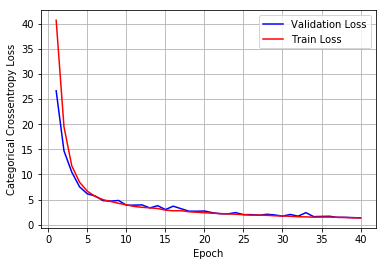

In [59]:
#This function is used to plot/update the train and test loss after each epoch.
import matplotlib.pyplot as plt
def plt_dynamic_loss(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax)

### Make predictions using a single image

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
import time


#Define image parameters. This should be same as the dimensions of the input image
img_width, img_height = 256, 256

#Make predictions using this function. Call this function with the file name
def predict_image(file):
    start = time.time()
    test_image = load_img(file, target_size=(img_width,img_height))
    test_image = img_to_array(test_image)
    test_image = test_image / 255.0
    test_image = np.expand_dims(test_image, axis=0)


    model = applications.VGG16(include_top=False, weights='imagenet')
    bottleneck_prediction = model.predict(test_image)  

    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(3, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    path='weights/bottleneck_feats_multi_weights.h5'
    model.load_weights(path)

    result = model.predict_classes(bottleneck_prediction) 
    
    if result[0] == 0:
        print("It's a Horse!")
    elif result[0] == 1:
        print("It's a Monkey!")
    elif result[0] == 2:
        print("It's a Tiger!")
        
    #Calculate execution time
    print("\nTest Time: ",np.round(time.time()-start,2),"seconds")

predict_image("test/tiger.jpg")

It's a Tiger!

Test Time:  2.37 seconds


### Visualize all the layers in the neural network

In [6]:
train_data = np.load('weights/bottleneck_features_train.npy')

model = applications.VGG16(include_top=False, weights='imagenet')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [44]:
import matplotlib.pyplot as plt
import matplotlib

def visualize_filters(layer, nrows, ncols):
    """Given a layer as an input, the function will plot all the filters present in that layer in x by y format.
    For example suppose our input layer is block1_conv1 and we have 32 feature maps. This function will display
    all the 32 feature maps in 8 X 4 view."""
    filters=layer.get_weights()
    fig=plt.figure(figsize=(50,25))
    for i in range(0,len(filters)):
        ax=fig.add_subplot(ncols,nrows,i+1)
        ax.matshow(filters[i][0][0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

visualize_filters(model.layers[1],4,16)

TypeError: 'Conv2D' object does not support indexing

ValueError: too many values to unpack (expected 2)

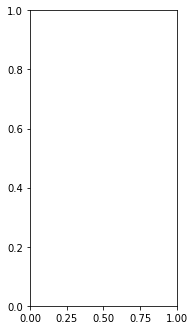

In [19]:
layer=model.layers[1]
filters=layer.get_weights()
filters[0][0][0][0]

(64,)

In [33]:
filters[0][3]

classifier.load_weights('best_weights.hdf5')

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

callbacks=[checkpointer] in fit_generator

"""The model will train for 30 epochs but we will use ModelCheckpoint to store the weights of the best performing epoch. 
We will specify val_acc as the metric to use to define the best model. This means we will keep the weights of the epoch that scores highest in terms of accuracy on the test set."""